In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
import sys

SOURCE_DIR = os.path.dirname(os.path.dirname(os.path.abspath(__name__)))
sys.path.insert(0, SOURCE_DIR)

In [3]:
import tensorflow as tf

tf.compat.v1.enable_eager_execution()

In [4]:
import malaya_speech.train.model.conformer as conformer
import malaya_speech.train.model.transducer as transducer
import malaya_speech
import tensorflow as tf
import numpy as np






The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [5]:
# !wget https://f000.backblazeb2.com/file/malaya-speech-model/v1/vocab/malaya-speech.tokenizer.subwords
# !wget https://f000.backblazeb2.com/file/malaya-speech-model/pretrained/asr-small-conformer-output.tar.gz
# !tar -zxf asr-small-conformer-output.tar.gz
# !ls asr-small-conformer-output

In [6]:
subwords = malaya_speech.subword.load('transducer.tokenizer')

In [7]:
featurizer = malaya_speech.tf_featurization.STTFeaturizer(
    normalize_per_feature = True
)

In [8]:
files = [
    '../speech/record/savewav_2020-11-26_22-36-06_294832.wav',
    '../speech/record/savewav_2020-11-26_22-40-56_929661.wav',
    '../speech/record/675.wav',
    '../speech/record/664.wav',
    '../speech/example-speaker/husein-zolkepli.wav',
    '../speech/example-speaker/mas-aisyah.wav',
    '../speech/example-speaker/khalil-nooh.wav',
    '../speech/example-speaker/shafiqah-idayu.wav',
    '../speech/khutbah/wadi-annuar.wav',
]

ys = [malaya_speech.load(f)[0] for f in files[:1]]
padded, lens = malaya_speech.padding.sequence_1d(ys, return_len = True)

In [9]:
X = tf.convert_to_tensor(padded.astype(np.float32))
X_len = tf.convert_to_tensor(lens)

In [10]:
# X = tf.compat.v1.placeholder(tf.float32, [None, None], name = 'X_placeholder')
# X_len = tf.compat.v1.placeholder(tf.int32, [None], name = 'X_len_placeholder')

In [11]:
batch_size = tf.shape(X)[0]
features = tf.TensorArray(dtype = tf.float32, size = batch_size, dynamic_size = True, infer_shape = False)
features_len = tf.TensorArray(dtype = tf.int32, size = batch_size)

init_state = (0, features, features_len)

def condition(i, features, features_len):
    return i < batch_size

def body(i, features, features_len):
    f = featurizer(X[i, :X_len[i]])
    f_len = tf.shape(f)[0]
    return i + 1, features.write(i, f), features_len.write(i, f_len)

_, features, features_len = tf.while_loop(condition, body, init_state)
features_len = features_len.stack()
padded_features = tf.TensorArray(dtype = tf.float32, size = batch_size)
padded_lens = tf.TensorArray(dtype = tf.int32, size = batch_size)
maxlen = tf.reduce_max(features_len)

init_state = (0, padded_features, padded_lens)

def condition(i, padded_features, padded_lens):
    return i < batch_size

def body(i, padded_features, padded_lens):
    f = features.read(i)
    len_f = tf.shape(f)[0]
    f = tf.pad(f, [[0, maxlen - tf.shape(f)[0]], [0,0]])
    return i + 1, padded_features.write(i, f), padded_lens.write(i, len_f)

_, padded_features, padded_lens = tf.while_loop(condition, body, init_state)
padded_features = padded_features.stack()
padded_lens = padded_lens.stack()
padded_lens.set_shape((None))
padded_features.set_shape((None, None, 80))
padded_features = tf.expand_dims(padded_features, -1)
padded_features, padded_lens

(<tf.Tensor: id=350, shape=(1, 598, 80, 1), dtype=float32, numpy=
 array([[[[-2.2034364 ],
          [-1.577853  ],
          [-1.4177448 ],
          ...,
          [-0.8329339 ],
          [-0.57104784],
          [-0.51345015]],
 
         [[-1.2287856 ],
          [-1.4864113 ],
          [-1.384421  ],
          ...,
          [-0.9460609 ],
          [-0.9094682 ],
          [-0.7640816 ]],
 
         [[-1.6237903 ],
          [-2.1593304 ],
          [-2.1062427 ],
          ...,
          [-0.8943915 ],
          [-0.92150915],
          [-0.9778747 ]],
 
         ...,
 
         [[-1.2223    ],
          [-1.4476264 ],
          [-1.3430028 ],
          ...,
          [-0.64533424],
          [-0.51785934],
          [-0.97902083]],
 
         [[-1.8572193 ],
          [-2.1320732 ],
          [-2.005242  ],
          ...,
          [-0.59267133],
          [-0.7728883 ],
          [-0.570435  ]],
 
         [[-0.7082459 ],
          [-1.2005471 ],
          [-1.1544559 ],
   

In [12]:
padded_features = tf.identity(padded_features, name = 'padded_features')
padded_lens = tf.identity(padded_lens, name = 'padded_lens')

In [13]:
config = malaya_speech.config.conformer_small_encoder_config
conformer_model = conformer.Model(**config)
decoder_config = malaya_speech.config.conformer_small_decoder_config
transducer_model = transducer.rnn.Model(
    conformer_model, vocabulary_size = subwords.vocab_size, **decoder_config
)

In [14]:
transducer_model.encoder.conv_subsampling.time_reduction_factor

4

In [15]:
# p = tf.compat.v1.placeholder(tf.int32, [None, None])
# z = tf.zeros((tf.shape(p)[0], 1),dtype=tf.int32)
# c = tf.concat([z, p], axis = 1)
# c

In [16]:
p = tf.constant([[2,2,2,2,2]])
z = tf.zeros((tf.shape(p)[0], 1),dtype=tf.int32)
c = tf.concat([z, p], axis = 1)
c

<tf.Tensor: id=365, shape=(1, 6), dtype=int32, numpy=array([[0, 2, 2, 2, 2, 2]], dtype=int32)>

In [17]:
l = tf.constant([6])

In [18]:
logits = transducer_model([padded_features, c, l], training = False)
logits


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


<tf.Tensor: id=12614, shape=(1, 150, 6, 1019), dtype=float32, numpy=
array([[[[-2.76941061e-01, -2.60642856e-01, -1.75765157e-03, ...,
          -2.16737702e-01,  5.91613829e-01,  5.78533053e-01],
         [-4.41472203e-01, -2.55001217e-01,  1.58214152e-01, ...,
          -1.11223325e-01,  7.46190548e-01,  4.71162140e-01],
         [-4.95740712e-01, -2.53666669e-01,  2.56271839e-01, ...,
          -1.96872503e-02,  8.31345797e-01,  3.93989265e-01],
         [-4.98325020e-01, -2.61838228e-01,  3.10256064e-01, ...,
           4.21543568e-02,  8.76945257e-01,  3.44420612e-01],
         [-4.79894221e-01, -2.74984956e-01,  3.38736534e-01, ...,
           7.84203559e-02,  9.04845238e-01,  3.13910723e-01],
         [-4.54447985e-01, -2.89010227e-01,  3.53366613e-01, ...,
           9.74038392e-02,  9.24812436e-01,  2.95339197e-01]],

        [[-1.83465496e-01, -3.93688977e-01, -1.25008374e-01, ...,
          -1.82381213e-01,  5.76377749e-01,  5.06338775e-01],
         [-3.22037280e-01, -4.111

In [19]:
transducer_model.load_weights('asr-small-conformer-output/model.ckpt')

Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


In [20]:
decoded = transducer_model.greedy_decoder(padded_features, padded_lens, training = False)
decoded = tf.identity(decoded, name = 'greedy_decoder')
decoded

<tf.Tensor: id=62985, shape=(1, 598), dtype=int32, numpy=
array([[  0, 596, 206,   0,   0,   0, 795,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0, 514,   0,   0,   0,   0,   0, 795,   0,
         30,   0,   0,   0,   0, 795,   0,   0,   0, 266,   0,   0,   0,
          0,   0,   0,   0, 175,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         30,   0,   0, 795,   0,  17,   0,   0,   0, 421,   0,   0,   0,
        795, 204,   0,   0,   0,   0,  27,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 405,   0,   0,
          0,  54,   0,   0,  30,   0,   0,   0,   0, 795,   0,   0,   0,
          0, 136,   0,   0,   0,   0,   0,   0,   0,   0, 870,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0

In [41]:
r = transducer_model.greedy_decoder_alignment(padded_features[:1], padded_lens[:1], training = False)

In [42]:
last_index = np.where(r[0].numpy() > 0)[1][-1]
last_index

140

In [43]:
l = r[0].numpy()[0,:last_index]
r = np.exp(r[1].numpy()[0,:last_index])

In [57]:
r.shape

(140, 1019)

In [56]:
s = tf.nn.softmax(r[:,l]).numpy()
s.shape

(140, 140)

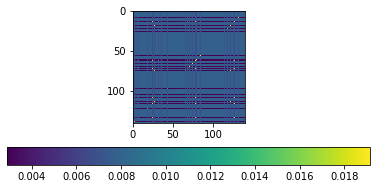

In [64]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(311)
im = ax1.imshow(np.rot90(s), interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

In [ ]:
encoded = transducer_model.encoder_inference(padded_features[0])
encoded

In [ ]:
encoded

In [ ]:
g = transducer_model._perform_greedy(encoded, tf.shape(encoded)[0],
                                tf.constant(0, dtype = tf.int32),
                                transducer_model.predict_net.get_initial_state())
g

In [ ]:
indices = g.prediction
minus_one = -1 * tf.ones_like(indices, dtype=tf.int32)
blank_like = 0 * tf.ones_like(indices, dtype=tf.int32)
indices = tf.where(indices == minus_one, blank_like, indices)

In [ ]:
num_samples = tf.cast(tf.shape(X[0])[0], dtype=tf.float32)
total_time_reduction_factor = featurizer.frame_step
stime = tf.range(0, num_samples, delta=total_time_reduction_factor, dtype=tf.float32)
stime /= tf.cast(featurizer.sample_rate, dtype=tf.float32)
etime = tf.range(total_time_reduction_factor, num_samples, delta=total_time_reduction_factor, dtype=tf.float32)
etime /= tf.cast(featurizer.sample_rate, dtype=tf.float32)
non_blank = tf.where(tf.not_equal(indices, 0))
non_blank_transcript = tf.gather_nd(indices, non_blank)
non_blank_stime = tf.gather_nd(tf.repeat(tf.expand_dims(stime, axis=-1), tf.shape(indices)[-1], axis=-1), non_blank)[:,0]

In [ ]:
malaya_speech.subword.decode(subwords, non_blank_transcript.numpy())

In [ ]:
subwords._id_to_subword(596 - 1), subwords._id_to_subword(206 - 1)

In [ ]:
non_blank_transcript

In [ ]:
non_blank_stime

In [ ]:
# beam_width = tf.placeholder(tf.int32, None, name = 'beam_width')
# decoded_beam = transducer_model.beam_decoder(padded_features, padded_lens, 
#                                              beam_width = beam_width, training = False)
# decoded_beam = tf.identity(decoded_beam, name = 'beam_decoder')
# decoded_beam

In [ ]:
encoded = transducer_model.encoder(padded_features, training = False)
encoded = tf.identity(encoded, name = 'encoded')
encoded_placeholder = tf.placeholder(tf.float32, [config['dmodel']], name = 'encoded_placeholder')
predicted_placeholder = tf.placeholder(tf.int32, None, name = 'predicted_placeholder')
t = transducer_model.predict_net.get_initial_state().shape
states_placeholder = tf.placeholder(tf.float32, [int(i) for i in t], name = 'states_placeholder')

ytu, new_states = transducer_model.decoder_inference(
    encoded=encoded_placeholder,
    predicted=predicted_placeholder,
    states=states_placeholder,
    training = True
)

ytu = tf.identity(ytu, name = 'ytu')
new_states = tf.identity(new_states, name = 'new_states')
ytu, new_states

In [ ]:
initial_states = transducer_model.predict_net.get_initial_state()
initial_states = tf.identity(initial_states, name = 'initial_states')

In [ ]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [ ]:
var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
saver = tf.train.Saver(var_list = var_list)
saver.restore(sess, 'asr-small-conformer-output/model.ckpt')

In [ ]:
r = sess.run([non_blank_transcript, non_blank_stime, non_blank_etime], feed_dict = {X: padded, X_len: lens})
r

In [ ]:
r[0].shape

In [ ]:
r[2].shape

In [ ]:
import collections
import numpy as np
import tensorflow as tf

BeamHypothesis = collections.namedtuple(
    'BeamHypothesis', ('score', 'prediction', 'states')
)


def transducer(
    enc,
    total,
    initial_states,
    encoded_placeholder,
    predicted_placeholder,
    states_placeholder,
    ytu,
    new_states,
    sess,
    beam_width = 10,
    norm_score = True,
):
    kept_hyps = [
        BeamHypothesis(score = 0.0, prediction = [0], states = initial_states)
    ]
    B = kept_hyps
    for i in range(total):
        A = B
        B = []
        while True:
            y_hat = max(A, key = lambda x: x.score)
            A.remove(y_hat)
            ytu_, new_states_ = sess.run(
                [ytu, new_states],
                feed_dict = {
                    encoded_placeholder: enc[i],
                    predicted_placeholder: y_hat.prediction[-1],
                    states_placeholder: y_hat.states,
                },
            )
            for k in range(ytu_.shape[0]):
                beam_hyp = BeamHypothesis(
                    score = (y_hat.score + float(ytu_[k])),
                    prediction = y_hat.prediction,
                    states = y_hat.states,
                )
                if k == 0:
                    B.append(beam_hyp)
                else:
                    beam_hyp = BeamHypothesis(
                        score = beam_hyp.score,
                        prediction = (beam_hyp.prediction + [int(k)]),
                        states = new_states_,
                    )
                    A.append(beam_hyp)
            if len(B) > beam_width:
                break
    if norm_score:
        kept_hyps = sorted(
            B, key = lambda x: x.score / len(x.prediction), reverse = True
        )[:beam_width]
    else:
        kept_hyps = sorted(B, key = lambda x: x.score, reverse = True)[
            :beam_width
        ]
    return kept_hyps[0].prediction

In [ ]:
%%time

r = sess.run(decoded, feed_dict = {X: padded, X_len: lens})
for row in r:
    print(malaya_speech.subword.decode(subwords, row[row > 0]))

In [ ]:
%%time

encoded_, padded_lens_  = sess.run([encoded, padded_lens], feed_dict = {X: padded, X_len: lens})
padded_lens_ = padded_lens_ // conformer_model.conv_subsampling.time_reduction_factor
s = sess.run(initial_states)

for i in range(len(encoded_)):
    r = transducer(
        enc = encoded_[i],
        total = padded_lens_[i],
        initial_states = s,
        encoded_placeholder = encoded_placeholder,
        predicted_placeholder = predicted_placeholder,
        states_placeholder = states_placeholder,
        ytu = ytu,
        new_states = new_states,
        sess = sess,
        beam_width = 1,
    )

    print(malaya_speech.subword.decode(subwords, r))

In [ ]:
saver = tf.train.Saver()
saver.save(sess, 'output/model.ckpt')

In [ ]:
strings = ','.join(
    [
        n.name
        for n in tf.get_default_graph().as_graph_def().node
        if ('Variable' in n.op
        or 'gather' in n.op.lower()
        or 'placeholder' in n.name
        or 'encoded' in n.name
        or 'decoder' in n.name
        or 'ytu' in n.name
        or 'new_states' in n.name
        or 'padded_' in n.name
        or 'initial_states' in n.name)
        and 'adam' not in n.name
        and 'global_step' not in n.name
        and 'Assign' not in n.name
        and 'ReadVariableOp' not in n.name
        and 'Gather' not in n.name
    ]
)
strings.split(',')

In [ ]:
def freeze_graph(model_dir, output_node_names):

    if not tf.gfile.Exists(model_dir):
        raise AssertionError(
            "Export directory doesn't exists. Please specify an export "
            'directory: %s' % model_dir
        )

    checkpoint = tf.train.get_checkpoint_state(model_dir)
    input_checkpoint = checkpoint.model_checkpoint_path

    absolute_model_dir = '/'.join(input_checkpoint.split('/')[:-1])
    output_graph = absolute_model_dir + '/frozen_model.pb'
    clear_devices = True
    with tf.Session(graph = tf.Graph()) as sess:
        saver = tf.train.import_meta_graph(
            input_checkpoint + '.meta', clear_devices = clear_devices
        )
        saver.restore(sess, input_checkpoint)
        output_graph_def = tf.graph_util.convert_variables_to_constants(
            sess,
            tf.get_default_graph().as_graph_def(),
            output_node_names.split(','),
        )
        with tf.gfile.GFile(output_graph, 'wb') as f:
            f.write(output_graph_def.SerializeToString())
        print('%d ops in the final graph.' % len(output_graph_def.node))

In [ ]:
freeze_graph('output', strings)

In [ ]:
def load_graph(frozen_graph_filename):
    with tf.gfile.GFile(frozen_graph_filename, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
                
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def)
        
    return graph

In [ ]:
g = load_graph('output/frozen_model.pb')

In [ ]:
input_nodes = [
    'X_placeholder',
    'X_len_placeholder',
    'encoded_placeholder',
    'predicted_placeholder',
    'states_placeholder',
]
output_nodes = [
    'greedy_decoder',
    'encoded',
    'ytu',
    'new_states',
    'padded_features',
    'padded_lens',
    'initial_states'
]
inputs = {n: g.get_tensor_by_name(f'import/{n}:0') for n in input_nodes}
outputs = {n: g.get_tensor_by_name(f'import/{n}:0') for n in output_nodes}

In [ ]:
test_sess = tf.InteractiveSession(graph = g)

In [ ]:
r = test_sess.run(outputs['greedy_decoder'], feed_dict = {inputs['X_placeholder']: padded, 
                                                          inputs['X_len_placeholder']: lens})

In [ ]:
for row in r:
    print(malaya_speech.subword.decode(subwords, row[row > 0]))

In [ ]:
encoded_, padded_lens_, s  = test_sess.run([outputs['encoded'], outputs['padded_lens'], outputs['initial_states']], 
                                        feed_dict = {inputs['X_placeholder']: padded, 
                                                     inputs['X_len_placeholder']: lens})

padded_lens_ = padded_lens_ // conformer_model.conv_subsampling.time_reduction_factor

In [ ]:
i = 0
r = transducer(
    enc = encoded_[i],
    total = padded_lens_[i],
    initial_states = s,
    encoded_placeholder = inputs['encoded_placeholder'],
    predicted_placeholder = inputs['predicted_placeholder'],
    states_placeholder = inputs['states_placeholder'],
    ytu = outputs['ytu'],
    new_states = outputs['new_states'],
    sess = test_sess,
    beam_width = 1,
)

malaya_speech.subword.decode(subwords, r)

In [ ]:
from tensorflow.tools.graph_transforms import TransformGraph

In [ ]:
transforms = ['add_default_attributes',
             'remove_nodes(op=Identity, op=CheckNumerics, op=Dropout)',
             'fold_batch_norms',
             'fold_old_batch_norms',
             'quantize_weights(fallback_min=-10, fallback_max=10)',
             'strip_unused_nodes',
             'sort_by_execution_order']

pb = 'output/frozen_model.pb'

input_graph_def = tf.GraphDef()
with tf.gfile.FastGFile(pb, 'rb') as f:
    input_graph_def.ParseFromString(f.read())

transformed_graph_def = TransformGraph(input_graph_def, 
                                           input_nodes,
                                           output_nodes, transforms)
    
with tf.gfile.GFile(f'{pb}.quantized', 'wb') as f:
    f.write(transformed_graph_def.SerializeToString())

In [ ]:
g = load_graph('output/frozen_model.pb.quantized')

In [ ]:
inputs = {n: g.get_tensor_by_name(f'import/{n}:0') for n in input_nodes}
outputs = {n: g.get_tensor_by_name(f'import/{n}:0') for n in output_nodes}
test_sess = tf.InteractiveSession(graph = g)

In [ ]:
r = test_sess.run(outputs['greedy_decoder'], feed_dict = {inputs['X_placeholder']: padded, 
                                                          inputs['X_len_placeholder']: lens})

In [ ]:
for row in r:
    print(malaya_speech.subword.decode(subwords, row[row > 0]))

In [ ]:
encoded_, padded_lens_, s  = test_sess.run([outputs['encoded'], outputs['padded_lens'], outputs['initial_states']], 
                                        feed_dict = {inputs['X_placeholder']: padded, 
                                                     inputs['X_len_placeholder']: lens})

padded_lens_ = padded_lens_ // conformer_model.conv_subsampling.time_reduction_factor

In [ ]:
i = 0
r = transducer(
    enc = encoded_[i],
    total = padded_lens_[i],
    initial_states = s,
    encoded_placeholder = inputs['encoded_placeholder'],
    predicted_placeholder = inputs['predicted_placeholder'],
    states_placeholder = inputs['states_placeholder'],
    ytu = outputs['ytu'],
    new_states = outputs['new_states'],
    sess = test_sess,
    beam_width = 1,
)

malaya_speech.subword.decode(subwords, r)

In [ ]:
# !rm -rf output asr-small-conformer-output